In [1]:
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import weibull_min
from scipy.signal import spectrogram
import networkx as nx
import pandas as pd
import bisect
import seaborn as sns
from sympy import symbols, solve
import json
from time import process_time


In [2]:
#Fixed parameters
sensitivity_steps = 1 #Number of parameter values scanned for sensitivity parameter specified below
simulations = 1
annual_decisions = 2 #Number of times an agent is evaluating strategy on average
households = 100
time = 1000
mu_farm = 163.4
farm_k = 0.808 #Shape factor for farming income distribution (Weibull)
alpha = 0.9 #Proportion of full farm income that is still earned by households engaging in migration
cost_farm = 170

mu_migrate = 594.8
var_migrate = 998.2
cost_migrate = 50

beta = 0.25 #Proportion of income that is shared in collective
p_drought = 0.2

utility_function = 'Moralis'

risk_factor = 0.5
altruism_factor = 0.5
k = 0.5 #Probability of an agent following another agent
sel_strength = 0.1 #Strength of selection effect
mutation_rate=0.01

In [3]:
#Define drought and non-drought portions of farming income distribution

def farm_drought(mu_farm, farm_k, p_drought):
    
    scale = (mu_farm / math.gamma(1 + 1 / farm_k))

    income_distribution = scale * np.random.weibull(farm_k, size=1000)
    sorted_income = list(np.sort(income_distribution))
    
    drought_threshold = int(p_drought * len(sorted_income))
    nondrought_incomes = sorted_income[drought_threshold:len(sorted_income)]
    
    if p_drought == 0:
        drought_incomes = nondrought_incomes
    else:
        drought_incomes = sorted_income[0:drought_threshold]
    
    
    mu_farm_drought = np.average(drought_incomes)
    mu_farm_nd = np.average(nondrought_incomes)
    
    var_drought = np.var(drought_incomes)
    var_nd = np.var(nondrought_incomes)
    
    return mu_farm_drought, mu_farm_nd, var_drought, var_nd
    
#Calculate variance from Weibull distribution parameters

def wei_var(mu, k):
    scale = (mu_farm / math.gamma(1 + 1 / farm_k))
    variance = scale ** 2 * (math.gamma(1 + 2 / farm_k) - (math.gamma(1 + 1 / farm_k)) ** 2)
    
    return variance


In [4]:
# Calculate expected income from strategy options as a function of strategy distribution

def income_calc(strategy_names, mu_farm, farm_k, alpha, mu_migrate, beta, frequency_dist, cost_farm, cost_migrate, p_drought):
    
    mu_farm_drought, mu_farm_nd = farm_drought(mu_farm, farm_k, p_drought)[0:2]
    
    #Income generated by own household
    farm_income = {'Farm': mu_farm, 
                     'FarmMigrate': mu_farm * alpha, 
                     'Farm+Share': mu_farm, 
                     'FarmMigrate+Share': mu_farm * alpha, 
                     'Farm+Ins': mu_farm_nd, 
                     'FarmMigrate+Ins': mu_farm_nd * alpha, 
                     'Farm+Share+Ins': mu_farm_nd, 
                     'FarmMigrate+Share+Ins': mu_farm_nd * alpha}
    
    remittances = {'Farm': 0, 
                   'FarmMigrate': mu_migrate, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': mu_migrate, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': mu_migrate, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': mu_migrate}
    
    shared_pool = 0
    shared_dist = 0
    for item in strategy_names:
        if 'Share' in item:
            shared_pool += beta * frequency_dist[item] * (farm_income[item] + remittances[item])
            shared_dist += frequency_dist[item]
    
    if shared_dist == 0:
        household_share = 0
    else:
        household_share = shared_pool / shared_dist
        
    shared_income_received = {'Farm': 0, 
                   'FarmMigrate': 0, 
                   'Farm+Share': household_share, 
                   'FarmMigrate+Share': household_share, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': 0, 
                   'Farm+Share+Ins': household_share, 
                   'FarmMigrate+Share+Ins': household_share}
    
    costs = {'Farm': cost_farm, 
            'FarmMigrate': cost_farm + cost_migrate, 
            'Farm+Share': cost_farm + beta * (farm_income['Farm+Share'] + remittances['Farm+Share']), 
            'FarmMigrate+Share': cost_farm + cost_migrate + beta * (farm_income['FarmMigrate+Share'] + remittances['FarmMigrate+Share']), 
            'Farm+Ins': cost_farm + p_drought * (mu_farm_nd - mu_farm_drought), 
            'FarmMigrate+Ins': cost_farm + cost_migrate + p_drought * alpha * (mu_farm_nd - mu_farm_drought), 
            'Farm+Share+Ins': cost_farm + p_drought * (mu_farm_nd - mu_farm_drought) + beta * (farm_income['Farm+Share+Ins'] + remittances['Farm+Share+Ins']), 
            'FarmMigrate+Share+Ins': cost_farm + cost_migrate + p_drought * alpha * (mu_farm_nd - mu_farm_drought) + beta * (farm_income['FarmMigrate+Share+Ins'] + remittances['FarmMigrate+Share+Ins'])}
    
    expected_payoffs = {}
    for item in strategy_names:
        expected_payoffs[item] = farm_income[item] + remittances[item] + shared_income_received[item] - costs[item]
    
    return expected_payoffs
        

In [5]:
#Variance calculation

def variance_calc(mu_farm, farm_k, p_drought, alpha, var_migrate, beta, frequency_dist, strategy_names):
    
    var_farm = wei_var(mu_farm, farm_k)
    var_farm_d, var_farm_nd = farm_drought(mu_farm, farm_k, p_drought)[2:4]
    
    variance = {'Farm': var_farm, 
                   'FarmMigrate': alpha * var_farm + var_migrate, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': 0, 
                   'Farm+Ins': (1 - p_drought) * var_farm_nd + p_drought * var_farm_d, 
                   'FarmMigrate+Ins': alpha * ((1 - p_drought) * var_farm_nd + p_drought * var_farm_d) + var_migrate, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': 0} 
    
    #Calculating variance of shared pool
    var_pool_num = 0
    pool_dist = 0
    for item in strategy_names:
        if 'Share' in item:
            equivalent = item.replace('+Share', '')
            var_pool_num += beta * frequency_dist[item] * variance[equivalent]
            pool_dist += frequency_dist[item]
    
    if pool_dist == 0:
        var_pool = 0
    else:
        var_pool = var_pool_num / pool_dist
    
    for item in strategy_names:
        if 'Share' in item:
            equivalent = item.replace('+Share', '')
            variance[item] = (1 - beta) * variance[equivalent] + var_pool
            

    return variance
            

In [6]:
# Calculation of homo economicus utility
def utility_calc(strategy_names, mu_farm, farm_k, alpha, mu_migrate, beta, frequency_dist, cost_farm, cost_migrate, p_drought, var_migrate, risk_factor):
    
    utilities = {'Farm': 0, 
                   'FarmMigrate': 0, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': 0, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': 0, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': 0} 
    
    income_matrix = income_calc(strategy_names, mu_farm, farm_k, alpha, mu_migrate, beta, frequency_dist, cost_farm, cost_migrate, p_drought)
    variance_matrix = variance_calc(mu_farm, farm_k, p_drought, alpha, var_migrate, beta, frequency_dist, strategy_names)
    
    for item in strategy_names:       
        utilities[item] = income_matrix[item] - risk_factor * math.sqrt(variance_matrix[item])
    
    return utilities

In [7]:
#Calculation of altruism utility function

#Need to do 8x8 matrix where we calculate the new distribution once for the whole timestep (rather than each time we go to a new agent)

def altruistic_util(prior_strategies, households, mu_farm, farm_k, alpha, mu_migrate, beta, cost_farm, cost_migrate, p_drought, risk_factor, altruism_factor):
    
    altruistic_matrix = {'Farm': {}, 
                   'FarmMigrate': {}, 
                   'Farm+Share': {}, 
                   'FarmMigrate+Share': {}, 
                   'Farm+Ins': {}, 
                   'FarmMigrate+Ins': {}, 
                   'Farm+Share+Ins': {}, 
                   'FarmMigrate+Share+Ins': {}}
    
    strategy_names = altruistic_matrix.keys()
    

    #Updating potential frequency distributions based on household switching to another strategy
    #Here, strategy is the choice the household made in previous time step. Name represents strategy they may switch to
    for strategy in strategy_names:
        altruistic_utilities = {'Farm': 0, 
                   'FarmMigrate': 0, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': 0, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': 0, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': 0} 
        
        for name in strategy_names:
            base_strategies = {'Farm': 0, 
                       'FarmMigrate': 0, 
                       'Farm+Share': 0, 
                       'FarmMigrate+Share': 0, 
                       'Farm+Ins': 0, 
                       'FarmMigrate+Ins': 0, 
                       'Farm+Share+Ins': 0, 
                       'FarmMigrate+Share+Ins': 0} 
            
            for item in strategy_names:
                base_strategies[item] = prior_strategies[item]
            #print('Initial distribution is:', base_strategies)   
            potential_dist = []        
            potential_dist.append(base_strategies)
            potential_dist.append(base_strategies)
           
            #Adjust strategy distributions based on one household switching to the strategy "name"
            if name != strategy and base_strategies[strategy] != 0:
                potential_dist[-1][name] = (potential_dist[-2][name] * households + 1) / households
                potential_dist[-1][strategy] = (potential_dist[-2][strategy] * households - 1) / households
                
                if potential_dist[-1][strategy] < 0:
                    raise ValueError('Distribution of:',strategy,'is negative')
            #print('Potential distribution is:', potential_dist[-1])
            #Re-calculating utility of each strategy, based on potential frequency distribution
            new_income = income_calc(strategy_names, mu_farm, farm_k, alpha, mu_migrate, beta, potential_dist[-1], cost_farm, cost_migrate, p_drought)
            new_variance = variance_calc(mu_farm, farm_k, p_drought, alpha, var_migrate, beta, potential_dist[-1], strategy_names)      
            
            new_utility = {key : 0 for key in strategy_names}
            for i in strategy_names:
                new_utility[i] = new_income[i] - risk_factor * math.sqrt(new_variance[i])
            
        
            #Calculating the aggregate utility of one's neighbors, given the potential frequency distribution
            others_utility = 0
            
            for j in strategy_names:
                if j == name:
                    others_utility += (potential_dist[-1][j] * households - 1) * new_utility[j]
                else:
                    others_utility += potential_dist[-1][j] * households * new_utility[j]
        
            altruistic_utilities[name] = new_utility[name] + altruism_factor * others_utility
        
        altruistic_matrix[strategy] = altruistic_utilities
        
        
        
    
    return altruistic_matrix
    
    
    
    

In [14]:
# Homo Moralis functions

#Function that returns probabilities of 1 --> N-1 agents adopting a strategy, given probability k
def binomial(households, k, proportion):
    current = int(proportion * households) #Existing number of households pursuing strategy
    n = households - current #Number of possible households to "convert"
    p = np.zeros(households)
    
    #If all households are already playing the strategy, assume it stays that way
    if current == households:
        p[current-1] = 1
    
    else:
        #Filling out probabilities for new converts, ranging from existing households to all households playing strategy
        for i in range(current+1, households):
            new_converts = i - current #Number of new converts needed to have i households play given strategy
            p[i] = scipy.special.comb(n, new_converts) * k ** (new_converts) * (1 - k) ** (n - new_converts)
    
        p[current] = 1 - np.sum(p) #Rest of probability remains with status quo
    
    return p

#Function that calculates probabilistic distributions for each strategy, given the prior strategy distribution
def moralis_prob(households, k, previous_dist):
    
    moralis_probabilities = {'Farm': np.zeros(households), 
                   'FarmMigrate': np.zeros(households), 
                   'Farm+Share': np.zeros(households), 
                   'FarmMigrate+Share': np.zeros(households), 
                   'Farm+Ins': np.zeros(households), 
                   'FarmMigrate+Ins': np.zeros(households), 
                   'Farm+Share+Ins': np.zeros(households), 
                   'FarmMigrate+Share+Ins': np.zeros(households)
                            }
    
    strategy_names = moralis_probabilities.keys()
    
    #Calculating probabilistic distributions for each strategy
    for strategy in strategy_names:
        moralis_probabilities[strategy] = binomial(households, k, previous_dist[strategy])
        
    return moralis_probabilities


#Function that calculates expected moralis utility, based on moralis probabilities calculated above
def moralis_utility(households, k, previous_dist, mu_farm, farm_k, alpha, mu_migrate, beta, cost_farm, cost_migrate, p_drought, risk_factor):
    strategy_names = previous_dist.keys()
    utility_matrix = {key : 0 for key in strategy_names}
    probability_matrix = moralis_prob(households, k, previous_dist)
    
    for strategy in utility_matrix.keys():
        probabilistic_income = np.zeros(households)
        probabilistic_variance = np.zeros(households)
        probabilistic_utility = np.zeros(households)
        
        for i in range(households):
            #Cutting off utility calculations for small probabilities
            if probability_matrix[strategy][i] < 0.0001:
                probabilistic_utility[i] = 0
            else:
                potential_dist = []
                moralis_dist = {key : 0 for key in strategy_names}
            
                #Calculates household strategy distribution for a given moralis probability
                moralis_dist[strategy] = (i) / households
            
                #Calculates distributions for other strategies, after accounting for same-strategy distribution
                for item in utility_matrix.keys():
                    if previous_dist[strategy] == 1:
                        moralis_dist[item] = 0
                    else:
                        moralis_dist[item] = previous_dist[item] / (1 - previous_dist[strategy]) * (1 - moralis_dist[strategy])
            
                potential_dist.append(moralis_dist)
                potential_dist.append(moralis_dist)
                probabilistic_income[i] = income_calc(strategy_names, mu_farm, farm_k, alpha, mu_migrate, beta, potential_dist[-1], cost_farm, cost_migrate, p_drought)[strategy]
                probabilistic_variance[i] = variance_calc(mu_farm, farm_k, p_drought, alpha, var_migrate, beta, potential_dist[-1], strategy_names)[strategy]
                probabilistic_utility[i] = probabilistic_income[i] - risk_factor * math.sqrt(probabilistic_variance[i])
        

        utility_matrix[strategy] = np.dot(probability_matrix[strategy], probabilistic_utility)
    
    return utility_matrix
          

In [9]:
#Assign households an updated strategy based on transition matrix

def household_update(strategy_panel, matrix):
    community_strategies = []

    for i in range(households):
        row = strategy_panel[-1][i]
        probabilities = matrix[row]
    
        draw = np.random.random()
        running_probability = 0
    
        for key,values in probabilities.items():
            running_probability += values
            
            if draw < running_probability:
                household_strategy = key
                draw = 1 #prevents strategy from being changed

        community_strategies.append(household_strategy)

    strategy_panel.append(community_strategies)

    return strategy_panel


In [10]:
#Select Utility Function
def utility_select(utility_function, strategy_names, risk_factor, prior_strategies, households, mu_farm, farm_k, alpha, mu_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, k):
    matrix = {key : 0 for key in strategy_names}
    if utility_function == 'Self-Interested':
        matrix = utility_calc(strategy_names, mu_farm, farm_k, alpha, mu_migrate, beta, prior_strategies, cost_farm, cost_migrate, p_drought, var_migrate, risk_factor)

    elif utility_function == 'Altruistic':
        matrix = altruistic_util(prior_strategies, households, mu_farm, farm_k, alpha, mu_migrate, beta, cost_farm, cost_migrate, p_drought, risk_factor, altruism_factor)
    elif utility_function == 'Moralis':
        matrix = moralis_utility(households, k, prior_strategies, mu_farm, farm_k, alpha, mu_migrate, beta, cost_farm, cost_migrate, p_drought, risk_factor)
    else:
        raise ValueError ('Utility function improperly specified')
    
    return matrix

#Calculate probability of switching from strategy x to y

def fermi_calc(households, strategies, i, t, function, matrix, sel_strength, mutation_rate):
    random_compare = np.random.randint(0,households) #Selects random neighbor with whom to compare
    
    #x_strategy = strategies[t-1][i] #Strategy of household i
    #y_strategy = strategies[t-1][random_compare] #Strategy of household j
    
    x_strategy = strategies[i] #Strategy of household i
    y_strategy = strategies[random_compare] #Strategy of household j
    
    #Picking utility based on type of utility function
    if utility_function == 'Altruistic':
        #For altruistic,utility_x represents sticking with same strategy; utility_y represents switching to utility_y
        #utility_x = altruistic_util(prior_strategies, households, mu_farm, farm_k, alpha, mu_migrate, beta, cost_farm, cost_migrate, p_drought, risk_factor, altruism_factor)
        #utility_y = altruistic_util(prior_strategies, households, mu_farm, farm_k, alpha, mu_migrate, beta, cost_farm, cost_migrate, p_drought, risk_factor, altruism_factor)
        utility_x = matrix[x_strategy][x_strategy]
        utility_y = matrix[x_strategy][y_strategy]
    else:
        utility_x = matrix[x_strategy]
        utility_y = matrix[y_strategy]
        
    #if function == 'altruistic':
        #utility_x = altruism_matrix[x_strategy]
        #utility_y = altruism_matrix[y_strategy]
    #elif function == 'moralis':
        #utility_x = moralis_matrix[x_strategy]
        #utility_y = moralis_matrix[y_strategy]
   # else:
        #utility_x = utility_matrix[x_strategy]
        #utility_y = utility_matrix[y_strategy]
    
    #Probability will be lower value (closer to 0) when selection strength and utility difference is high
    remain_probability = (1 + math.exp(sel_strength * (utility_y - utility_x))) ** (-1)

    draw = np.random.random()
    
    if draw > remain_probability:
        new_strategy = y_strategy
    else:
        new_strategy = x_strategy

    mutation_draw = np.random.random()
    
    if mutation_draw < mutation_rate:
        strategy_names = list(matrix.keys())
        strategy_index = np.random.randint(0, int(len(strategy_names)))
        new_strategy = strategy_names[strategy_index]
    
    return new_strategy
    
    

In [11]:
#Count number of households playing a given strategy in time t

def strategy_dist(strategy_panel, strategy_names, households):
    current_strategies = strategy_panel
    strategy_distribution = {'Farm': 0, 'FarmMigrate': 0, 'Farm+Share': 0, 'FarmMigrate+Share': 0, 'Farm+Ins': 0, 'FarmMigrate+Ins': 0, 'Farm+Share+Ins': 0, 'FarmMigrate+Share+Ins': 0}

    for strategy in strategy_names:
        strategy_distribution[strategy] = current_strategies.count(strategy) / households

    return strategy_distribution




## Initialize Model

In [12]:
#Initializing Model

def _init_(households):

    frequency_matrix = {'Farm': 0, 
                  'FarmMigrate': 0, 
                  'Farm+Share': 0, 
                  'FarmMigrate+Share': 0, 
                  'Farm+Ins': 0, 
                  'FarmMigrate+Ins': 0, 
                  'Farm+Share+Ins': 0, 
                  'FarmMigrate+Share+Ins': 0}

    initial_strategies = []
    strategy_names = list(frequency_matrix.keys())
    options = len(strategy_names)

    for i in range(households):
        draw = np.random.randint(0,options)
        initial_strategies.append(strategy_names[draw])
    
    return initial_strategies

In [15]:
#Loop through time steps
t1_start = process_time()
sens_frequency_dist = []

for step in range(sensitivity_steps):
    sim_frequency_dist = []
    
    init_sens_parameter = 0.5
    final_sens_parameter = 0.5
    
    if sensitivity_steps == 1:
        sens_parameter = init_sens_parameter
    else:
        sens_parameter = step * (final_sens_parameter - init_sens_parameter) / (sensitivity_steps-1) + init_sens_parameter
    
    altruism_factor = sens_parameter

    strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
    
    
    
    for a in range(simulations):
        initial_strategies = _init_(households)
        #strategies = [''] * time
        strategies = [''] * households
        #strategies[0] = initial_strategies[a]
        strategies = initial_strategies
        frequency_dist = []
        #frequency_dist.append(strategy_dist(strategies[0], strategy_names, households))
        frequency_dist.append(strategy_dist(strategies, strategy_names, households))
        #Note - Leave commented functions in for now. May want to switch to updating 1 at a time
        for t in range(1, time):
            print(t)
            #strategies[t] = strategies[t-1]
            #household_strategies = []
            #income_matrix = income_calc(strategy_names, mu_farm, farm_k, alpha, mu_migrate, beta, frequency_dist, cost_farm, cost_migrate, p_drought)
            #var_matrix = variance_calc(mu_farm, farm_k, p_drought, alpha, var_migrate, beta, frequency_dist, strategy_names)
            matrix = utility_select(utility_function, strategy_names, risk_factor, frequency_dist[-1], households, mu_farm, farm_k, alpha, mu_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, k)

            i = np.random.randint(0,households-1)
            updated_strategy = fermi_calc(households, strategies, i, t, utility_function, matrix, sel_strength, mutation_rate)
            strategies[i] = updated_strategy
            #for i in range(households):
                #updated_strategy = fermi_calc(households, strategies, i, t, utility_function, matrix, sel_strength, mutation_rate)
                #updated_strategy = fermi_calc(households, strategies, frequency_dist, i, t, utility_function, sel_strength, mutation_rate, mu_farm, farm_k, alpha, mu_migrate, beta, cost_farm, cost_migrate, p_drought, risk_factor, k, altruism_factor)
                #household_strategies.append(updated_strategy)
                #remaining_strategies = strategies[t][(i+1):households] #Strategies for households that have not yet been updated
                #strategies[t] = updated_strategies + remaining_strategies
            
            #strategies[t] = household_strategies
            #frequency_dist.append(strategy_dist(strategies[t], strategy_names,households))
            frequency_dist.append(strategy_dist(strategies, strategy_names,households))
        sim_frequency_dist.append(frequency_dist)
    sens_frequency_dist.append(sim_frequency_dist)

t1_stop = process_time()
print('Elapsed Time:', (t1_stop - t1_start) / 60)
prefix = 'AltruismSens'
#np.save(str(prefix) + '_frequencydist.npy', sens_frequency_dist)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


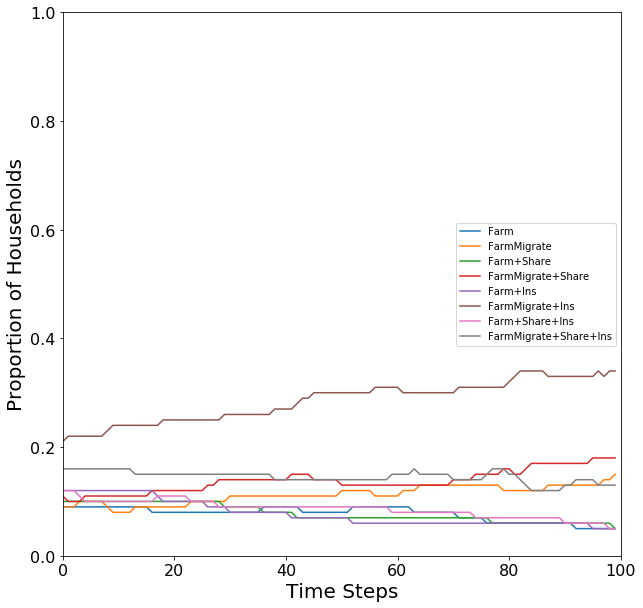

In [15]:
#Plot of strategy distribution over time

#Create arrays for proportion of households in any strategy over time

local_variables = {}

for item in strategy_names:
    var_name = str(item)
    local_variables[var_name] = np.zeros(time)


for t in range(time):
    for var_name, item in zip(local_variables.keys(), strategy_names):      
        local_variables[var_name][t] = sim_frequency_dist[0][t][item]

f, ax1 = plt.subplots(figsize=[10,10])
x = np.arange(time)
for key, value in local_variables.items():
    ax1.plot(x, value, label=key)

#ax1.plot(x, local_variables['FarmMigrate+Ins_prop'], linestyle='--')
#print(local_variables['FarmMigrate+Ins_prop'])
plt.legend(loc = 'center right')
ax1.set_ylim([0,1])
ax1.set_xlim([0, time])
ax1.set_xlabel('Time Steps', size=20)
ax1.set_ylabel('Proportion of Households', size=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

#plt.savefig('ExampleAltruism_alpha1.eps', bbox_inches='tight')


In [18]:
#Plot of average strategy distribution over time

#Create arrays for proportion of households in any strategy over time

local_variables = {}
avg_proportion = {}


for item in strategy_names:
    var_name = str(item)
    local_variables[var_name] = np.zeros((simulations,time))
    avg_time_proportion[var_name] = np.zeros(time)

for a in range(simulations):
    for t in range(time):
        for var_name, item in zip(local_variables.keys(), strategy_names):      
            local_variables[var_name][a,t] = sim_frequency_dist[a][t][item]

for var_name in local_variables.keys():
    for t in range(time):
        avg_time_proportion[var_name][t] = np.average(local_variables[var_name][:,t])
    
    avg_proportion[var_name] = np.average(avg_time_proportion[var_name])
    
f, ax1 = plt.subplots(figsize=[10,10])
x = np.arange(time)
for key, value in avg_proportion.items():
    ax1.plot(x, value, label=key)

#ax1.plot(x, local_variables['FarmMigrate+Ins_prop'], linestyle='--')
#print(local_variables['FarmMigrate+Ins_prop'])
plt.legend()
ax1.set_ylim([0,1])
ax1.set_xlim([0, time])

ax1.set_xlabel('Time Steps', size=20)
ax1.set_ylabel('Proportion of Households', size=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

#plt.savefig('Altruism05.eps', bbox_inches='tight')


NameError: name 'avg_time_proportion' is not defined

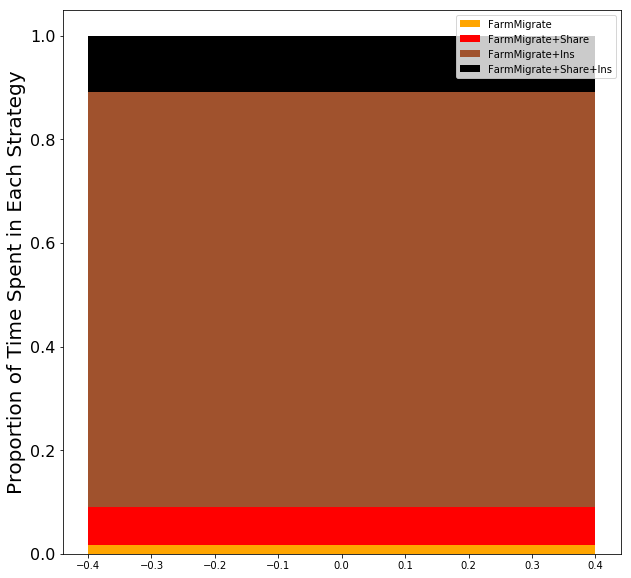

In [19]:
#Bar Graph of average strategy distributions over simulations

#Create arrays for proportion of households in any strategy over time

local_variables = {}
avg_time_proportion = {}
avg_proportion={}


for item in strategy_names:
    var_name = str(item)
    local_variables[var_name] = np.zeros((simulations,time))
    avg_time_proportion[var_name] = np.zeros(time)

for a in range(simulations):
    for t in range(time):
        for var_name, item in zip(local_variables.keys(), strategy_names):      
            local_variables[var_name][a,t] = sim_frequency_dist[a][t][item]

for var_name in local_variables.keys():
    for t in range(time):
        avg_time_proportion[var_name][t] = np.average(local_variables[var_name][:,t])
    
    avg_proportion[var_name] = np.average(avg_time_proportion[var_name])



f, ax = plt.subplots(figsize=[10,10])
x = np.arange(time)

categories = np.arange(1)
ax.bar(categories, avg_proportion['FarmMigrate'], label='FarmMigrate', color='orange')
ax.bar(categories, avg_proportion['FarmMigrate+Share'], bottom=avg_proportion['FarmMigrate'], label='FarmMigrate+Share', color='red')
ax.bar(categories, avg_proportion['FarmMigrate+Ins'], bottom=(avg_proportion['FarmMigrate+Share'] + avg_proportion['FarmMigrate']), label='FarmMigrate+Ins', color='sienna')
ax.bar(categories, avg_proportion['FarmMigrate+Share+Ins'], bottom=(avg_proportion['FarmMigrate+Ins'] + avg_proportion['FarmMigrate+Share'] + avg_proportion['FarmMigrate']), label='FarmMigrate+Share+Ins', color='black')

#ax1.plot(x, local_variables['FarmMigrate+Ins_prop'], linestyle='--')
#print(local_variables['FarmMigrate+Ins_prop'])
plt.legend()

#ax1.set_xlabel('Time Steps', size=20)
ax.set_ylabel('Proportion of Time Spent in Each Strategy', size=20)

plt.yticks(fontsize=16)
plt.show()

#np.save(avg_proportion, 'P0.3_proportion_10sim.npy')

#print(type(avg_proportion))
#data = json.dumps(avg_proportion)
#f = open("P0.01_proportion.json","w")
#f.write(data)
#f.close()

#plt.savefig('Altruism05_10sim.eps', bbox_inches='tight')

In [11]:
# Create Bar plot with separate bars for each drought probability tested

probabilities = [0.01, 0.05, 0.1, 0.3]
local_variables = {}
means = {'FarmMigrate':[], 'FarmMigrate+Share':[], 'FarmMigrate+Ins':[], 'FarmMigrate+Share+Ins':[]}



for item in probabilities:
    
    f = open('P' + str(item) + '_proportion.json',)
    var_name = ('p_' + str(item))
    local_variables[var_name] = json.load(f)
    f.close()


categories = means.keys()

for strategy in categories:
    for key,value in local_variables.items():
        means[strategy].append(local_variables[key][strategy])

probability_order = list(local_variables.keys())

f, ax = plt.subplots(figsize=[10,10])

bottom_1 = means['FarmMigrate']
bottom_2 = [means['FarmMigrate'][i] + means['FarmMigrate+Share'][i] for i in range(len(means['FarmMigrate']))]
bottom_3 = [means['FarmMigrate'][i] + means['FarmMigrate+Share'][i] + means['FarmMigrate+Ins'][i] for i in range(len(means['FarmMigrate']))]

#[test_list1[i] + test_list2[i] for i in range(len(test_list1))]
ax.bar(probability_order, means['FarmMigrate'], label = 'FarmMigrate', color='dodgerblue')
ax.bar(probability_order, means['FarmMigrate+Share'], bottom = bottom_1, label = 'FarmMigrate+Share', color='green')
ax.bar(probability_order, means['FarmMigrate+Ins'], bottom = bottom_2, label = 'FarmMigrate+Ins', color='salmon')
ax.bar(probability_order, means['FarmMigrate+Share+Ins'], bottom = bottom_3, label = 'FarmMigrate+Share+Ins', color='darkorchid')

ax.set_xlabel('Drought Probability', size=18)
ax.set_ylabel('Proportion of Time', size=18)


plt.legend(fontsize=16)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


#plt.show()

plt.savefig('DroughtSensitivity.eps', bbox_inches='tight')

In [41]:
mu_farm_drought

NameError: name 'mu_farm_drought' is not defined